<a href="https://colab.research.google.com/github/kili-technology/kili-python-sdk/blob/master/recipes/pixel_level_masks.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Importing segmentation pre-annotations

In this tutorial, we will show you how to import prediction labels into your Kili project. By doing that, you will see these predictions as pre-annotations in your labeling interface, and you will then be able to modify or validate them.

We will discover this feature on a [segmentation project](https://docs.kili-technology.com/docs/semantic-segmentation) that aims at working with images or videos with pixel-level annotations.

The data used in this tutorial is from the [COCO dataset](http://cocodataset.org/#explore?id=219921).

## Import an image into your Kili project

Let's first inspect what our annotated image looks like in COCO dataset.


Raw image             |  With the annotations
:-------------------------:|:-------------------------:
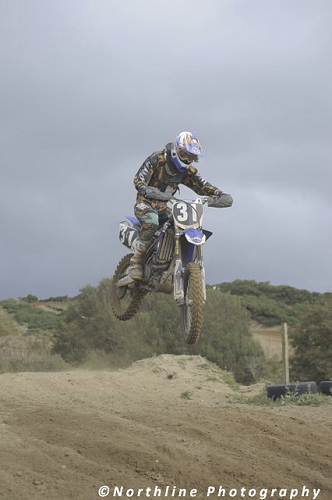 | 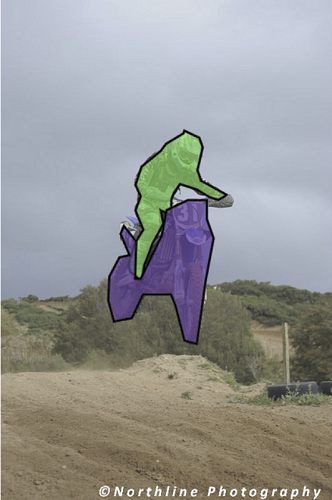

Before starting, we install the requirements:

In [ ]:
!pip install matplotlib Pillow kili opencv-python

In [ ]:
%matplotlib inline

import functools
import time
import json
import matplotlib.pyplot as plt
import numpy as np
import os
import getpass
import requests
from PIL import Image
from random import randint
import cv2
from kili.client import Kili

Let's authenticate to Kili:

In [ ]:
if "KILI_API_KEY" not in os.environ:
    KILI_API_KEY = getpass.getpass("Please enter your API key: ")
else:
    KILI_API_KEY = os.environ["KILI_API_KEY"]

kili = Kili(api_key=KILI_API_KEY)

Let's create an image project in Kili where we can annotate images with a "semantic" tool and two classes: `HUMAN` and `MOTORCYCLE` at pixel level.

We create the image project with its ontology (json_interface):

In [ ]:
json_interface = {
    "jobs": {
        "JOB_0": {
            "mlTask": "OBJECT_DETECTION",
            "tools": ["semantic"],
            "instruction": None,
            "required": 1,
            "isChild": False,
            "content": {
                "categories": {
                    "MOTORCYCLE": {"name": "Motorcycle", "children": [], "color": "#0755FF"},
                    "HUMAN": {"name": "Human", "children": [], "color": "#EEBA00"},
                },
                "input": "radio",
            },
        }
    }
}

In [ ]:
project = kili.create_project(
    description="COCO dataset",
    input_type="IMAGE",
    json_interface=json_interface,
    title="Motorcycle annotation",
)

project_id = project["id"]

Then, we upload the image to the project:

In [ ]:
external_id = "moto"
content = "https://farm7.staticflickr.com/6153/6181981748_6a225c275d_z.jpg"

kili.append_many_to_dataset(
    project_id=project_id,
    content_array=[content],
    external_id_array=[external_id],
    json_content_array=None,
);

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  1.37it/s]


You should now be able to visualize your asset in Kili:

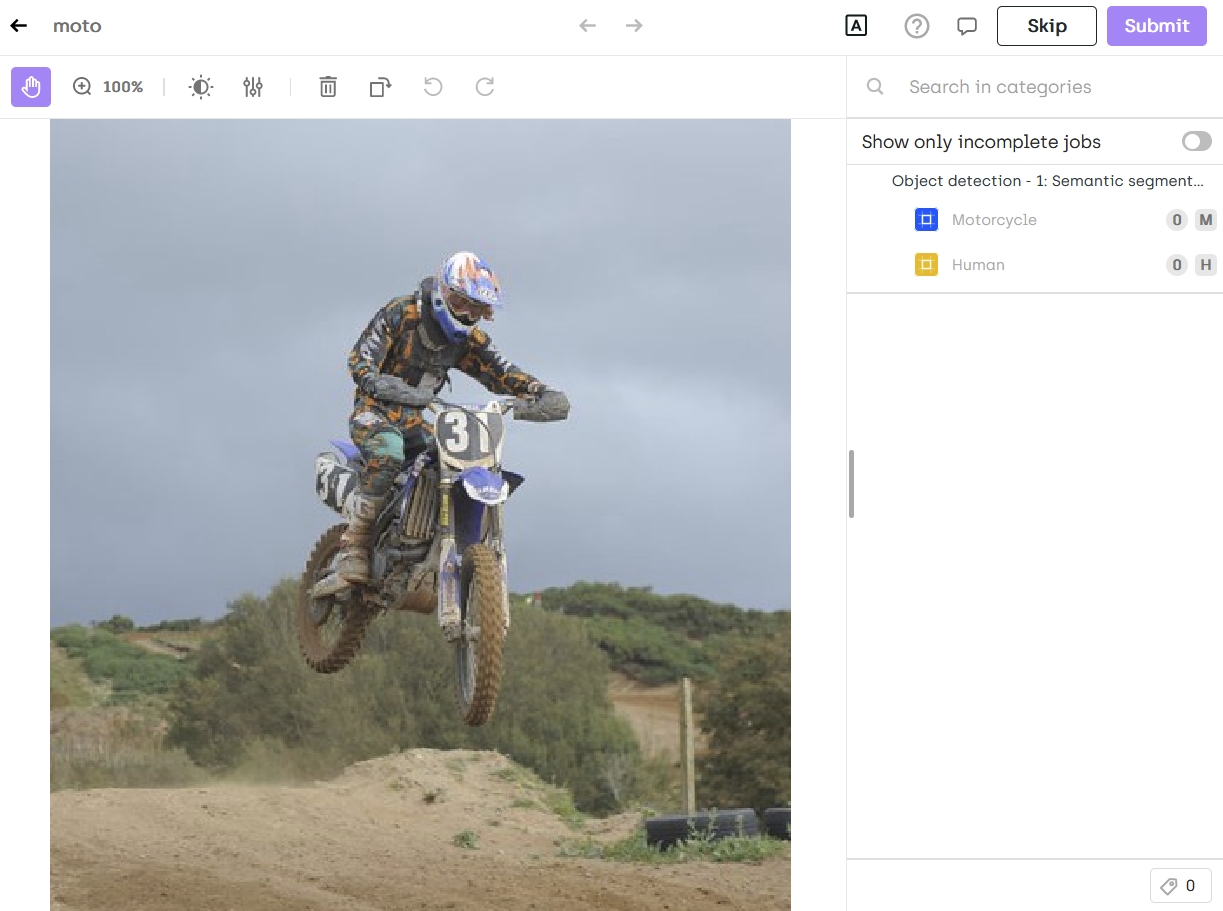

## Import annotations from a mask

Now, imagine you already have annotations stored as a mask. You want to insert it in Kili Technology as a [prediction](https://docs.kili-technology.com/recipes/importing-labels-and-predictions). Here is what the mask looks like:

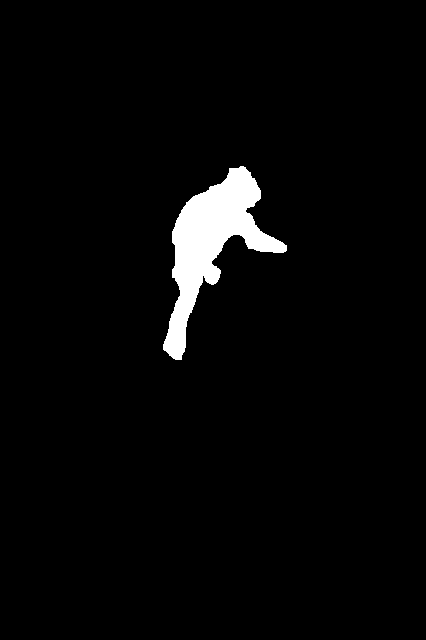

We can start by downloading the image on disk:

In [ ]:
mask_image_link = "https://raw.githubusercontent.com/kili-technology/kili-python-sdk/master/recipes/img/HUMAN.mask.png"
with open("mask.png", "wb") as f:
    content = requests.get(mask_image_link).content
    f.write(content)

These two functions will help us convert the mask:

In [ ]:
def cv_to_kili(polygons, shape, category_name):
    """
    Converts OpenCV polygons to Kili annotations (called JSON response)
    """
    y_max, x_max, _ = shape
    xy_max = max(x_max, y_max)
    if xy_max == 0:
        raise Exception("input image has zero size")
    normalized_polygons = []
    for polygon in polygons:
        normalized_polygon = []
        for point in polygon:
            x = point[0][0]
            y = point[0][1]
            normalized_polygon.append({"x": x / x_max, "y": y / y_max})
        normalized_polygons.append(normalized_polygon)
    annotations = []
    for normalized_polygon in normalized_polygons:
        annotations.append(
            {
                "boundingPoly": [{"normalizedVertices": normalized_polygon}],
                "categories": [{"name": category_name, "confidence": 100}],
                "mid": randint(100, 1000),
                "score": None,
                "type": "polygon",
            }
        )
    return {"JOB_0": {"annotations": annotations}}


def create_polygons_from_mask(image):
    grey_image = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, threshold = cv2.threshold(grey_image, 127, 255, 0)
    contours, _ = cv2.findContours(threshold, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
    return contours

We use these two methods to create the annotation (jsonResponse), and upload it to Kili as a prediction:

In [ ]:
mask_img = cv2.imread("mask.png")
polygons = create_polygons_from_mask(mask_img)
json_response = cv_to_kili(polygons, mask_img.shape, "HUMAN")

kili.create_predictions(
    project_id=project_id,
    external_id_array=[external_id],
    json_response_array=[json_response],
    model_name="original_mask",
)

That's it! Your mask was just converted to Kili Technology's standard format and uploaded as a prediction to the platform:

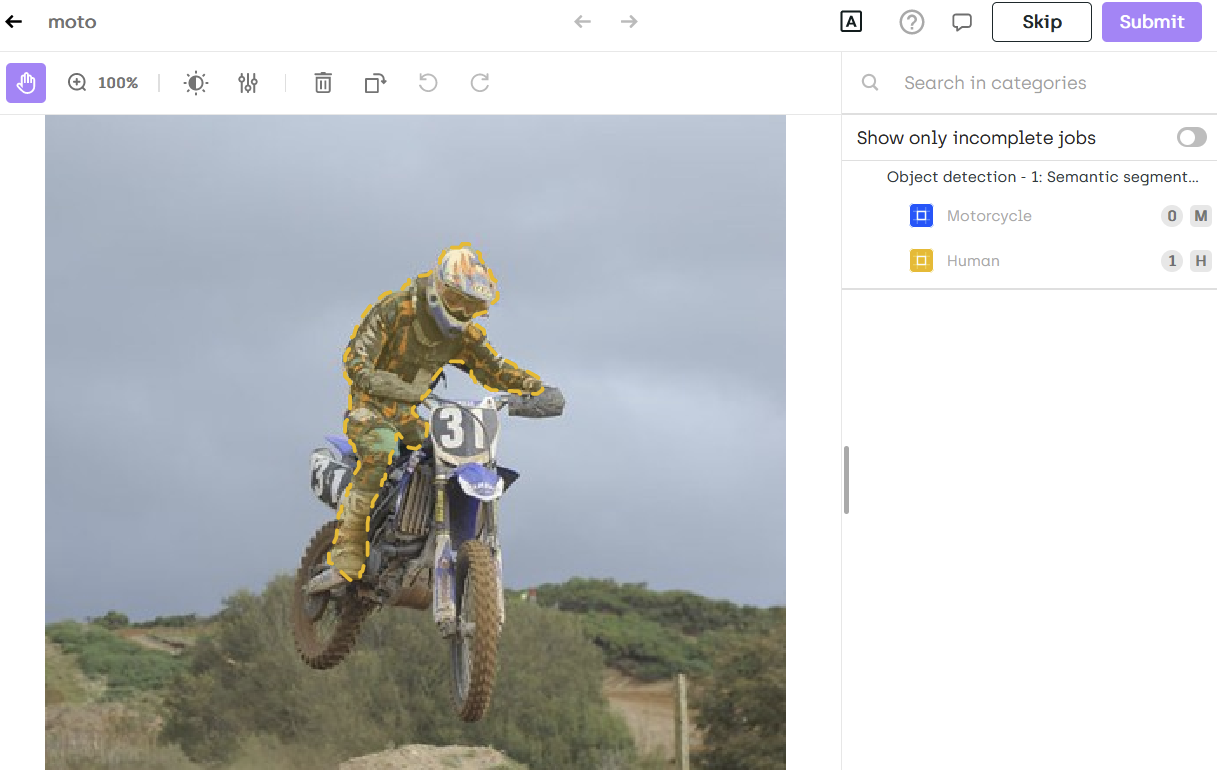

## Export the annotations as a mask

You may want to do the reverse operation, that is download the annotation from Kili and convert it back as a mask.

Let's see how you can achieve this!

First we define a function to convert jsonResponse (annotation) from Kili Technology to readable polygons in OpenCV:

In [ ]:
def kili_to_cv(json_response, shape):
    """
    Converts Kili annotations (called JSON response) to OpenCV format
    """
    y, x, _ = shape
    polygons = {}
    for job_name in json_response:
        job = json_response[job_name]
        if "annotations" not in job:
            continue
        annotations = job["annotations"]
        for annotation in annotations:
            categories = annotation["categories"]
            category = functools.reduce(lambda acc, cat: acc + cat["name"], categories, "")
            vertices = annotation["boundingPoly"][0]["normalizedVertices"]
            polygon = [[int(vertice["x"] * x), int(vertice["y"] * y)] for vertice in vertices]
            if category not in polygons:
                polygons[category] = [polygon]
            else:
                polygons[category].append(polygon)
    return polygons

Then, we can retrieve the jsonResponse and plot the mask:

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:00<00:00,  4.08it/s]


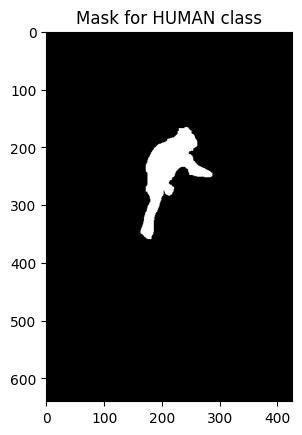

In [ ]:
labels = kili.labels(
    project_id=project_id, asset_external_id_in=[external_id], fields=["jsonResponse"]
)
label = labels[0]
json_response = label["jsonResponse"]

polygons = kili_to_cv(json_response, mask_img.shape)

mask = np.zeros(mask_img.shape[:2])
cv2.fillPoly(mask, np.array(polygons["HUMAN"], dtype=np.int32), 1)
plt.title(f"Mask for HUMAN class")
plt.imshow(mask, cmap="gray")
plt.show()

## Cleanup

We can remove the project that we created:

In [ ]:
kili.delete_project(project_id);

## Conclusion

You can now try uploading your own predictions using `kili.create_predictions()`!